# Выбор метода бинарной классификации

- Fields: `AccountId`, `SubscriptionId`, `CustomerId`, `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy` - Probability Encoder
- Fields: `TransactionId`, `BatchId`, `TransactionStartTime` - drop
- Fields: `Amount`, `Value` - Robust Scaler

In [1]:
import numpy  as np
import pandas as pd

In [3]:
df_trn = pd.read_csv('../data/training_pe.csv')
df_tst = pd.read_csv('../data/test_pe.csv')
df_sbm = pd.read_csv('../data/sample_submission.csv')

## Prepare

In [4]:
list(df_trn.columns)

['BatchId',
 'AccountId',
 'SubscriptionId',
 'CustomerId',
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'Amount',
 'Value',
 'TransactionStartTime',
 'PricingStrategy',
 'FraudResult']

### Drop

In [5]:
columns4drop = [
    'BatchId', 
    'TransactionStartTime'
]

In [6]:
df_trn = df_trn.drop(columns4drop, axis=1)
df_tst = df_tst.drop(columns4drop, axis=1)

In [7]:
df_trn.head()

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult
0,0.000000,0.000000,0.0,0.000088,0.000390,0.000400,0.003232,1000.0,1000,0.001741,0
1,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-20.0,20,0.001741,0
2,0.000000,0.000000,0.0,0.000088,0.000000,0.000400,0.003232,500.0,500,0.001741,0
3,0.000000,0.000000,0.0,0.010101,0.002646,0.006250,0.003232,20000.0,21800,0.001741,0
4,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-644.0,644,0.001741,0


### Scaling

In [8]:
from sklearn.preprocessing import RobustScaler

In [9]:
def scaleColumns(data, cols_to_scale, scaler):
    for col in cols_to_scale:
        data[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data[col])))
    return data

In [10]:
df_trn = scaleColumns(df_trn, ['Amount', 'Value'], RobustScaler())
df_tst = scaleColumns(df_tst, ['Amount', 'Value'], RobustScaler())

In [11]:
df_trn.head()

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult
0,0.000000,0.000000,0.0,0.000088,0.000390,0.000400,0.003232,0.000000,0.000000,0.001741,0
1,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.357895,-0.207407,0.001741,0
2,0.000000,0.000000,0.0,0.000088,0.000000,0.000400,0.003232,-0.175439,-0.105820,0.001741,0
3,0.000000,0.000000,0.0,0.010101,0.002646,0.006250,0.003232,6.666667,4.402116,0.001741,0
4,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.576842,-0.075344,0.001741,0


In [12]:
X = df_trn.drop('FraudResult', axis=1)
y = df_trn['FraudResult']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, shuffle=y)

In [15]:
from collections import Counter

In [16]:
print('Train Label Distribution: {}'.format(Counter(y_train)))
print('Test  Label Distribution: {}'.format(Counter(y_test)))

Train Label Distribution: Counter({0: 76380, 1: 149})
Test  Label Distribution: Counter({0: 19089, 1: 44})


## Train

In [17]:
# Classifier Libraries
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier

In [23]:
classifiers = {
    'Naive Bayes                       ': GaussianNB(),
    'k-Nearest Neighbors               ': KNeighborsClassifier(3),
    'Decision Tree Classifier          ': DecisionTreeClassifier(max_depth=5),
    'Logisitic Regression              ': LogisticRegression(),
    'AdaBoost Classifier               ': AdaBoostClassifier(),
    'Bagging Classifier                ': BaggingClassifier(),
    'Extra-Trees Classifier            ': ExtraTreesClassifier(),
    'Gradient Boosting                 ': GradientBoostingClassifier(),
    'Random Forest                     ': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     'Histogram-based GradBoostClassTree': HistGradientBoostingClassifier(),
    'Linear Discriminant Analysis      ': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis   ': QuadraticDiscriminantAnalysis(),
    'Multilayer Perceptron             ': MLPClassifier(alpha=1, max_iter=1000)
}
#     'Voting Classifier              ': VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft'),

In [24]:
from time import time
import warnings
warnings.filterwarnings("ignore")

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [30]:
# iterate over classifiers
print('Classifiers                            Precision  Recall     F1-score   b_accuracy ROC_AUC    Fit-time')
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    cv_results = cross_validate(classifier, X_train.value, y_train.value,
                                scoring=('precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'),
                                cv=5, n_jobs=-1)

    precision    = cv_results['test_precision'].mean()
    recall       = cv_results['test_recall'].mean()
    f1           = cv_results['test_f1'].mean()
    bal_accuracy = cv_results['test_balanced_accuracy'].mean()
    roc_auc      = cv_results['test_roc_auc'].mean()
    fit_time     = cv_results['fit_time'].sum()
    print('%s %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f' % 
          (name, precision, recall, f1, bal_accuracy, roc_auc, fit_time))

Classifiers                            Precision  Recall     F1-score   b_accuracy ROC_AUC   Fit-time
Naive Bayes                            0.1505     0.9798     0.2608     0.9845     0.9882     0.0833
k-Nearest Neighbors                    0.8896     0.8320     0.8566     0.9159     0.9662     3.1411
Decision Tree Classifier               0.8997     0.8926     0.8948     0.9462     0.9761     0.1995
Logisitic Regression                   0.7112     0.5106     0.5926     0.7551     0.9991     1.4221
AdaBoost Classifier                    0.8959     0.8726     0.8805     0.9362     0.9995     5.2598
Bagging Classifier                     0.8862     0.8791     0.8820     0.9394     0.9629     1.3518
Extra-Trees Classifier                 0.8890     0.8526     0.8698     0.9262     0.9730     0.5628
Gradient Boosting                      0.7468     0.6894     0.7087     0.8445     0.7661    13.6239
Random Forest                          0.8727     0.6837     0.7558     0.8417     0.9906 

**Old Results (Fields `Amount` and `Value` only)**

In [38]:
# iterate over classifiers
print('Classifiers \t\t\t Precision \t Recall \t F1-score \t Fit-time')
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    cv_results = cross_validate(classifier, X_train.values, y_train.values, scoring=('precision', 'recall', 'f1'), cv=5, n_jobs=-1)
    print(name,
          round(cv_results['test_precision'].mean(), 5), ' \t',
          round(cv_results['test_recall'].mean(),    5), ' \t',
          round(cv_results['test_f1'].mean(),        5), ' \t',
          round(cv_results['fit_time'].sum(),        2))

Classifiers 			 Precision 	 Recall 	 F1-score 	 Fit-time
Naive Bayes                        0.33918  	 0.91862  	 0.49315  	 0.14
k-Nearest Neighbors                0.92856  	 0.78414  	 0.84204  	 1.51
Decision Tree Classifier           0.95122  	 0.79793  	 0.86306  	 0.19
Logisitic Regression               0.6549  	 0.30207  	 0.40272  	 0.51
AdaBoost Classifier                0.972  	 0.77126  	 0.8561  	 4.7
Bagging Classifier                 0.9343  	 0.77793  	 0.84449  	 1.22
Extra-Trees Classifier             0.94058  	 0.7977  	 0.85633  	 0.44
Gradient Boosting                  0.76201  	 0.45793  	 0.52727  	 7.34
Random Forest                      0.95052  	 0.79126  	 0.85891  	 0.78
Histogram-based GradBoostClassTree 0.0  	 0.0  	 0.0  	 2.23
Linear Discriminant Analysis       0.53255  	 0.40253  	 0.45522  	 0.16
Quadratic Discriminant Analysis    0.25181  	 0.89839  	 0.39199  	 0.06
Multilayer Perceptron              0.5109  	 0.36207  	 0.42073  	 37.82


In [73]:
# iterate over classifiers
print('Classifiers \t\t\t Precision \t Recall \t F1-score \t Fit-time')
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    cv_results = cross_validate(classifier, X_train, y_train,
                                scoring=('precision', 'recall', 'f1'), cv=5, n_jobs=-1)

    print(name,
          round(cv_results['test_precision'].mean(), 4), ' \t',
          round(cv_results['test_recall'].mean(),    4), ' \t',
          round(cv_results['test_f1'].mean(),        4), ' \t',
          round(cv_results['fit_time'].sum(),        2))

Classifiers 			 Precision 	 Recall 	 F1-score 	 Fit-time
Naive Bayes                        0.3392  	 0.9186  	 0.4932  	 0.13
k-Nearest Neighbors                0.9286  	 0.7841  	 0.842  	 1.51
Decision Tree Classifier           0.9512  	 0.7979  	 0.8631  	 0.18
Logisitic Regression               0.6549  	 0.3021  	 0.4027  	 0.49
AdaBoost Classifier                0.972  	 0.7713  	 0.8561  	 4.32
Bagging Classifier                 0.9515  	 0.7977  	 0.8622  	 1.19
Extra-Trees Classifier             0.9515  	 0.7977  	 0.8622  	 0.44
Gradient Boosting                  0.762  	 0.4579  	 0.5273  	 6.42
Random Forest                      0.9515  	 0.8046  	 0.8671  	 0.72
Histogram-based GradBoostClassTree 0.0  	 0.0  	 0.0  	 2.15
Linear Discriminant Analysis       0.5326  	 0.4025  	 0.4552  	 0.2
Quadratic Discriminant Analysis    0.2518  	 0.8984  	 0.392  	 0.05
Multilayer Perceptron              0.6456  	 0.2821  	 0.3792  	 40.58


## Test

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = 2\cdot\frac{Precision\cdot{Recall}}{Precision+Recall}$

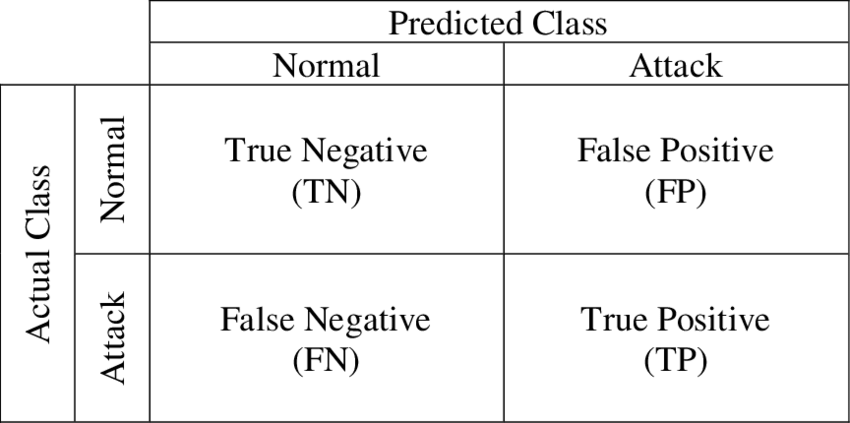

In [44]:
# iterate over classifiers
print(' '*29, 'Confusion-Matrix')
print('Classifiers', ' '*25, 'TN    FP')
print(' '*37, 'FN    TP   Precision    Recall     F1-score   b_accuracy ROC_AUC')
print('=' * 105)
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    predict = classifier.predict(X_test)

    tn, fp, fn, tp    = confusion_matrix(y_test, predict).ravel()
    precision         = precision_score(y_test, predict)
    recall            = recall_score(y_test, predict)    
    f1                = f1_score(y_test, predict)
    balanced_accuracy = balanced_accuracy_score(y_test, predict)
    roc_auc           = roc_auc_score(y_test, predict)

    print('%s %5i %5i'                                    % (' '*34, tn, fp))
    print('%s %5i %5i %10.4f %10.4f %10.4f %10.4f %10.4f' % (name, fn, tp, precision, recall, f1, balanced_accuracy, roc_auc))
#     print('-'*110)

                              Confusion-Matrix
Classifiers                           TN    FP
                                      FN    TP   Precision    Recall     F1-score   b_accuracy ROC_AUC
                                   18902   187
Naive Bayes                            0    44     0.1905     1.0000     0.3200     0.9951     0.9951
                                   19088     1
k-Nearest Neighbors                    4    40     0.9756     0.9091     0.9412     0.9545     0.9545
                                   19085     4
Decision Tree Classifier               2    42     0.9130     0.9545     0.9333     0.9772     0.9772
                                   19084     5
Logisitic Regression                  18    26     0.8387     0.5909     0.6933     0.7953     0.7953
                                   19086     3
AdaBoost Classifier                    3    41     0.9318     0.9318     0.9318     0.9658     0.9658
                                   19083     6
Bagging Cla

**Old Results (Fields `Amount` and `Value` only)**

In [80]:
# iterate over classifiers
print('Classifiers \t\t\t     TN     FP    FN    TP   Precision    Recall     F1-score')
print('-' * 95)
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    predict = classifier.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    precision      = precision_score(y_test, predict)
    recall         = recall_score(y_test, predict)
    f1             = f1_score(y_test, predict)

    print('%s %5i %5i %5i %5i %10.4f %10.4f %10.4f' % (name, tn, fp, fn, tp, precision, recall, f1))

Classifiers 			      TN    FP    FN    TP   Precision    Recall     F1-score
----------------------------------------------------------------------------------------------------
Naive Bayes                        19026    63     2    42     0.4000     0.9545     0.5638
k-Nearest Neighbors                19086     3     3    41     0.9318     0.9318     0.9318
Decision Tree Classifier           19089     0     6    38     1.0000     0.8636     0.9268
Logisitic Regression               19086     3    30    14     0.8235     0.3182     0.4590
AdaBoost Classifier                19089     0     7    37     1.0000     0.8409     0.9136
Bagging Classifier                 19089     0     6    38     1.0000     0.8636     0.9268
Extra-Trees Classifier             19089     0     6    38     1.0000     0.8636     0.9268
Gradient Boosting                  19083     6    28    16     0.7273     0.3636     0.4848
Random Forest                      19089     0     6    38     1.0000     0.8636     0

## Submitting

In [45]:
X.head()

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,0.000000,0.000000,0.0,0.000088,0.000390,0.000400,0.003232,0.000000,0.000000,0.001741
1,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.357895,-0.207407,0.001741
2,0.000000,0.000000,0.0,0.000088,0.000000,0.000400,0.003232,-0.175439,-0.105820,0.001741
3,0.000000,0.000000,0.0,0.010101,0.002646,0.006250,0.003232,6.666667,4.402116,0.001741
4,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.576842,-0.075344,0.001741


In [46]:
df_tst.head()

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,0.000000,0.000000,0.0,0.004401,0.000493,0.000400,0.003232,0.000000,-0.042553,0.000811
1,0.000000,0.000000,0.0,0.004401,0.013123,0.003546,0.003232,0.198020,0.170213,0.001741
2,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.207921,-0.244681,0.001741
3,0.000000,0.000000,0.0,0.004401,0.000390,0.000400,0.003232,0.396040,0.382979,0.000811
4,0.000032,0.000031,0.0,0.000131,0.000031,0.003546,0.000135,-0.209901,-0.242553,0.001741


In [47]:
classifiers = {
#     'Naive Bayes                       ': GaussianNB(),
    'k-Nearest Neighbors               ': KNeighborsClassifier(3),
    'Decision Tree Classifier          ': DecisionTreeClassifier(max_depth=5),
    'Logisitic Regression              ': LogisticRegression(),
    'AdaBoost Classifier               ': AdaBoostClassifier(),
    'Bagging Classifier                ': BaggingClassifier(),
    'Extra-Trees Classifier            ': ExtraTreesClassifier(),
    'Gradient Boosting                 ': GradientBoostingClassifier(),
    'Random Forest                     ': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     'Histogram-based GradBoostClassTree': HistGradientBoostingClassifier(),
    'Linear Discriminant Analysis      ': LinearDiscriminantAnalysis(),
#     'Quadratic Discriminant Analysis   ': QuadraticDiscriminantAnalysis(),
    'Multilayer Perceptron             ': MLPClassifier(alpha=1, max_iter=1000)
}

In [48]:
for name, classifier in classifiers.items():
    classifier.fit(X, y)
    predict = classifier.predict(df_tst)

    print(name, ':', Counter(predict))
    df_sbm['FraudResult'] = predict
    df_sbm.to_csv('../submitted/AlBo0717_' + name.rstrip().replace(' ', '_') + '.csv', encoding='utf-8', index=False)

k-Nearest Neighbors                : Counter({0: 44975, 1: 44})
Decision Tree Classifier           : Counter({0: 44969, 1: 50})
Logisitic Regression               : Counter({0: 44994, 1: 25})
AdaBoost Classifier                : Counter({0: 45015, 1: 4})
Bagging Classifier                 : Counter({0: 44954, 1: 65})
Extra-Trees Classifier             : Counter({0: 45008, 1: 11})
Gradient Boosting                  : Counter({0: 44956, 1: 63})
Random Forest                      : Counter({0: 45015, 1: 4})
Linear Discriminant Analysis       : Counter({0: 44992, 1: 27})
Multilayer Perceptron              : Counter({0: 44972, 1: 47})


## Results on ZINDI
- `k-Nearest Neighbors                : 0.52               down`
- `Decision Tree Classifier           : 0.583333333333333  stay`
- `Logisitic Regression               : 0.390243902439024  down`
- `AdaBoost Classifier                : 0.0740740740740741 down`
- `Bagging Classifier                 : 0.642857142857143  down` 
- `Extra-Trees Classifier             : 0.3125             down`
- `Gradient Boosting                  : 0.654545454545455    up` === 1-st place === 
- `Random Forest                      : 0.0740740740740741 down`
- `Linear Discriminant Analysis       : 0.428571428571429  down`
- `Multilayer Perceptron              : 0.549019607843137    up`

**Old Results (Fields `Amount` and `Value` only)**

In [89]:
for name, classifier in classifiers.items():
    classifier.fit(X, y)
    predict = classifier.predict(df_tst)

    print(name, ':', Counter(predict))
    df_sbm['FraudResult'] = predict
    df_sbm.to_csv('../submitted/AlBo0713_' + name.rstrip().replace(' ', '_') + '.csv', encoding='utf-8', index=False)

k-Nearest Neighbors                : Counter({0: 44972, 1: 47})
Decision Tree Classifier           : Counter({0: 44969, 1: 50})
Logisitic Regression               : Counter({0: 44971, 1: 48})
AdaBoost Classifier                : Counter({0: 44965, 1: 54})
Bagging Classifier                 : Counter({0: 44946, 1: 73})
Extra-Trees Classifier             : Counter({0: 44967, 1: 52})
Gradient Boosting                  : Counter({0: 45001, 1: 18})
Random Forest                      : Counter({0: 44926, 1: 93})
Linear Discriminant Analysis       : Counter({0: 44968, 1: 51})
Multilayer Perceptron              : Counter({0: 44994, 1: 25})


## Results on ZINDI
- 'k-Nearest Neighbors               ': 0.549019607843137
- 'Decision Tree Classifier          ': 0.583333333333333
- 'Logisitic Regression              ': 0.528301886792453
- 'AdaBoost Classifier               ': 0.6
- 'Bagging Classifier                ': 0.688524590163934
- 'Extra-Trees Classifier            ': 0.592592592592593
- 'Gradient Boosting                 ': 0.4
- 'Random Forest                     ': 0.694444444444444 === 1-st place ===
- 'Linear Discriminant Analysis      ': 0.555555555555556
- 'Multilayer Perceptron             ': 0.512820512820513

In [ ]:
classifiers_sc = {
    'Support Vector Classifier, Linear': SVC(kernel="linear", C=0.025),
    'Support Vector Classifier, RBF   ': SVC(kernel="rbf", gamma=2, C=1),
}

In [ ]:
# iterate over classifiers_sc
print('Classifiers \t\t Cross_val_score \t Time')
for name, classifier in classifiers_sc.items():
    tac = time()
    classifier.fit(X_sc_train, y_sc_train)
    training_score = cross_val_score(classifier, X_sc_train, y_sc_train, cv=5)
    tic = time()
    print(name, round(training_score.mean(), 5), ' \t', round(tic-tac, 2))

In [41]:
from sklearn.metrics import make_scorer

In [42]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp),
           'tn': make_scorer(tn),
           'fp': make_scorer(fp),
           'fn': make_scorer(fn)}

In [ ]:
cv_results = cross_validate(svm.fit(X, y), X, y, scoring=scoring, cv=5)
# Getting the test set true positive scores
print(cv_results['test_tp'])  

# Getting the test set false negative scores
print(cv_results['test_fn'])  

In [ ]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))